<a href="https://colab.research.google.com/github/lollokill/crypto-trading-bot/blob/master/SimulationsMC-swing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Exemple de référence

def american_mc(T,N,steps,S,r,sigma,K, typeCP):
	import numpy as np
	if typeCP=="call":
		typeCP=1
	else:
		typeCP=-1

	dt = np.float(T) / steps
	df = np.exp(-r * dt)
	# simulation of index levels
	SPath = np.zeros((steps + 1, N))
	SPath[0] = S

	z=np.random.randn(steps,N)

	for t in range(1, steps + 1):
		SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])

	# case-based calculation of payoff
	h = np.maximum(typeCP*(SPath - K), 0)
	# LSM algorithm
	V = np.copy(h)
	for t in range(steps - 1, 0, -1):
		reg = np.polyfit(SPath[t], V[t + 1] * df, 7)
		C = np.polyval(reg, SPath[t])
		V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
	# MCS estimator
	option = df * 1 / N * np.sum(V[1])
	return option

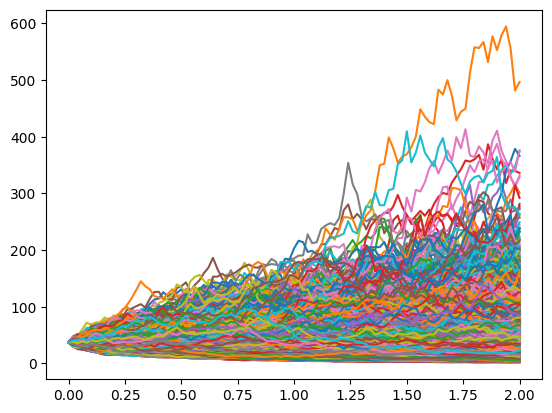

Les quantiles d'ordre 5%, 50%, 95% [  9.44454535  30.48395527 101.03923575]
Le temps de calcul est de : 10.786663553999972
Moyenne :  39.623601990062326


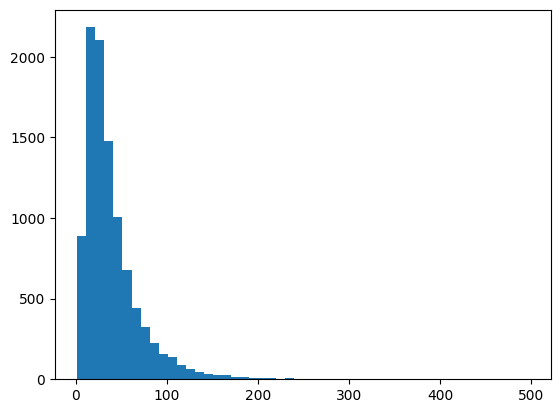

In [6]:
## Création d'un échantillon Normal : Df = F*sigma*dBt
def normal_mc(T,N,steps,S,r,sigma, show=False):
  import numpy as np

  dt = float(T) / steps
  # simulation of index levels
  SPath = np.zeros((steps + 1, N))
  SPath[0] = S

  z=np.random.randn(steps,N)

  for t in range(1, steps + 1):
    SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])

  if show:
    import matplotlib.pyplot as plt
    time=[i*dt for i in range(steps+1)]
    for i in range(N):
      plt.plot(time, SPath[:,i])
    plt.show()
  return SPath

## Visualisation des simulations et détermination des quantiles (utiles en terme de gestion de risque ?) + Affichage temps de calcul
import numpy as np
import time
import matplotlib.pyplot as plt

start=time.perf_counter()
mc_test=normal_mc(2,10000,100,37.189,0.03,0.5,show = True)
end=time.perf_counter()


print("Les quantiles d'ordre 5%, 50%, 95%",np.quantile(mc_test[100],[0.05,0.5,0.95]))
#print("Le pourcentile de 1 est :",np.percentile(mc_test[100],1))
print("Le temps de calcul est de :",end-start)
plt.hist(mc_test[100],bins=50)
print("Moyenne : ",np.mean(mc_test[100]))

In [7]:
!pip install -q pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 97.1 MB/s eta 0:00:00


In [11]:
from random import *
import matplotlib.pyplot as plt
import numpy as np

from pulp import *


def res_mipl(T,trials,steps,K,r,s,qmin,qmax,Qmin,Qmax, debug = False,typeCP="call"):
        if typeCP=="call":
                typeCP=1
        else:
                typeCP=-1

  #Constructions des valeurs utiles
        dt=float(T)/steps

        #Construction du modele
        model = LpProblem("Maximisation_sur_une_trajectoire",LpMaximize)

        variable_names = [i for i in range(0,steps)]

        #Variables
        f=LpVariable.matrix("f",variable_names)

        i=LpVariable.matrix("i",variable_names,cat="Integer",lowBound=0,upBound=1)

        c = LpAffineExpression([ (f[k],typeCP*(s[k]-K)*np.exp(-r*dt*k)) for k in range(len(f))])
        model+= c

        #Contraintes
        for k in range(steps):
                model+= (f[k]<=i[k]*qmax)
                model+= (f[k]>=i[k]*qmin)
        model+= (Qmin<=lpSum(f))
        model+= (lpSum(f)<=Qmax)
        model+= (lpSum(i)<=trials)

        #Resolution
        if debug :
                print(model)
        model.solve()
        z=[model.variables()[k].value()*(s[k]-K)*np.exp(-dt*r*k) for k in range(steps)]
        obj=0
        for k in range(steps):
                obj+=z[k]
        result= [model.variables()[k].value() for k in range(steps)]
        if debug :
                print([model.variables()[k] for k in range(steps)])
                print([model.variables()[k].value() for k in range(steps)])
                print(lpSum(z))
                import matplotlib.pyplot as plt
                plt.plot(s-K)
                print(result)
        return result, obj

def american_mc(T,N,steps,S,r,sigma,K,typeCP,h,show=False):
        if typeCP=="call":
                typeCP=1
        else:
                typeCP=-1

        dt = float(T) / steps
        df = np.exp(-r * dt)
        # simulation of index levels
        SPath = np.zeros((steps + 1, N))
        SPath[0] = S

        z=np.random.randn(steps,N)

        for t in range(1, steps + 1):
                SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])

        #On cherche les qtes qui maximisent les payoffs avec les contraintes
        # f=np.zeros((steps + 1, N))
        # for i in range(N):
        #       f[1:,i]=res_mipl(T,nb_ex,steps,K,r,SPath,qmini,qmaxi,Qmin,Qmax,debug = False)


        #Montrer la figure
        if show:
                time=[i*dt for i in range(steps+1)]
                for i in range(N):
                        plt.plot(time, SPath[:,i])
                plt.show()


        # case-based calculation of payoff
        # h = np.zeros((steps + 1, N))
        # for i in range(1,steps+1):
        #       for j in range(N):
        #               h[i,j]=np.maximum(f[i,j]*typeCPb*(SPath[i,j] - K), 0)
        # LSM algorithm
        V = np.copy(h)
        for t in range(steps - 1, 0, -1):
                reg = np.polyfit(SPath[t], V[t + 1] * df, 7)
                C = np.polyval(reg, SPath[t])
                V[t] = np.where(C > h[t], SPath[t+1]*df, h[t])
        # MCS estimator

        return V


def swing(T,N,steps,S,r,sigma,K,typeCP,nb_ex,Qmin,Qmax,qmini,qmaxi,show=False):
        if typeCP=="call":
                typeCPb=1
        else:
                typeCPb=-1

        dt = float(T) / steps
        df = np.exp(-r * dt)
        # simulation of index levels
        SPath = np.zeros((steps + 1, N))
        SPath[0] = S

        z=np.random.randn(steps,N)

        for t in range(1, steps + 1):
                SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])


        f=np.zeros((steps + 1, N))
        for i in range(N):
                (a,b)=res_mipl(T,nb_ex,steps,K,r,SPath[1:,i],qmini,qmaxi,Qmin,Qmax,debug = False,typeCP=typeCP)
                f[1:,i]=np.transpose(a)


        if show:
                time=[i*dt for i in range(steps+1)]
                for i in range(N):
                        plt.plot(time, SPath[:,i])
                plt.show()


        # LSM algorithm

        h = np.zeros((steps + 1, N))
        for i in range(1,steps+1):
                for j in range(N):
                        h[i,j]=np.maximum(f[i,j]*typeCPb*(SPath[i,j] - K), 0)

        option=np.zeros((nb_ex,steps+1,N))
        for k in range(nb_ex):
                option[k,:,:]=np.copy(h)

        for n in range(nb_ex):
                if n==0:
                        option[n,:,:]=american_mc(T,N,steps,S,r,sigma,K,typeCP,h)
                else:
                        for t in range(steps - 1, 0, -1):
                                reg = np.polyfit(SPath[t],option[n,t + 1,:]*df, 15)
                                C = np.polyval(reg, SPath[t])
                                option[n,t,:] = np.where(C > h[t]+option[n-1,t,:],option[n,t+1,:]*df,h[t]+option[n-1,t,:])
                        # MCS estimator
        #print(option)
        prix_swing = df * 1 / N * np.sum(option[nb_ex-1,1,:])

        return prix_swing

In [13]:
#Test
import time

start=time.perf_counter()
price =swing(T=1/12,N=100,steps=21,S=37.18,r=0.02,sigma=0.6,K=40.5,typeCP="call",nb_ex=1,Qmin=0,Qmax=1,qmini=0,qmaxi=1,show=False)
end=time.perf_counter()


#Résultats test
print("Le prix de la swing est de :",price)
print("Le temps de calcul est de :",end-start)
print("Soit un temps par essai de :",(end-start)/100)

Le prix de la swing est de : 37.32746719970877
Le temps de calcul est de : 1.7098865589999832
Soit un temps par essai de : 0.01709886558999983


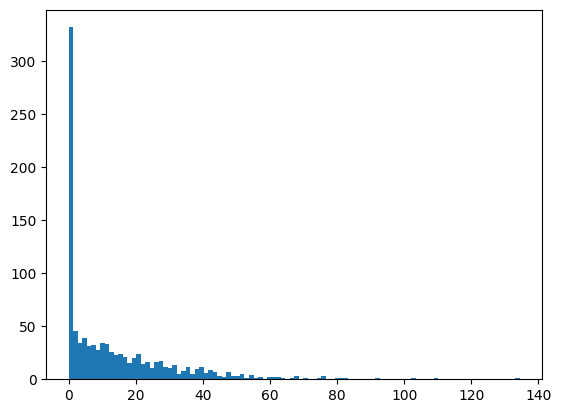

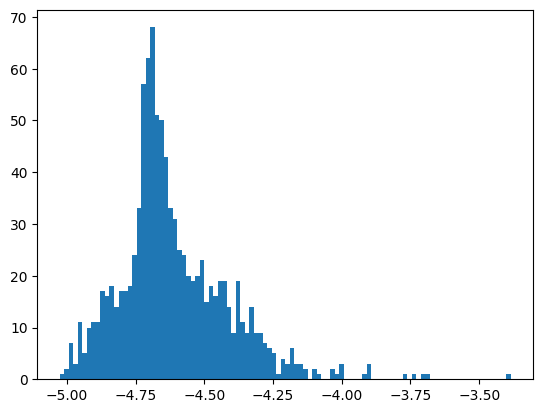

Durée d'exécution premier algo : 10.12865767200185
Price première méthode : 13.442834183027134


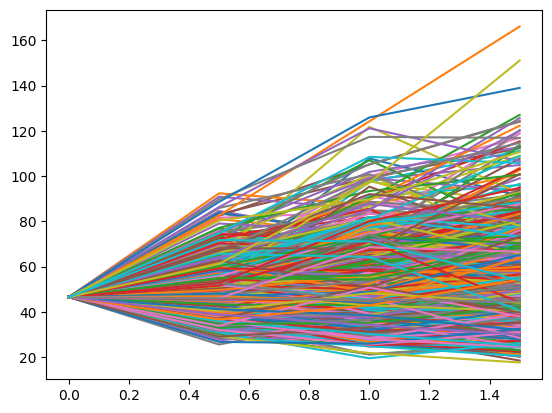

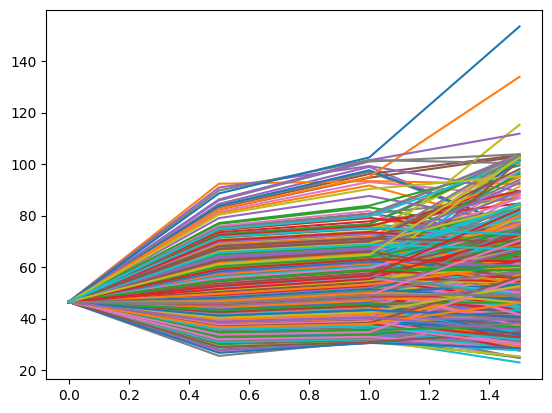

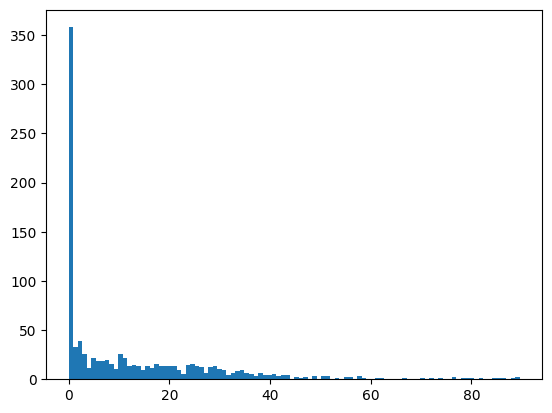

Durée exécution deuxième algo : 11.271691758999964
Price deuxième méthode : 12.349326635468886


In [15]:
#Méthode facile mais devrait légèrement surévaluer de par la méthode de calcul...
def swing_MC_naif(T,N,trials,steps,S,r,sigma,K,qmin,qmax,Qmin,Qmax,typeCP="call"):
  '''
  Cette fonction prend
  '''
  sum=0
  for m in range(N):
    s=normal_mc(T,1,steps,S,r,sigma, show=False)
    (a,b)=res_mipl(T,trials,steps,K,r,s,qmin,qmax,Qmin,Qmax, debug = False,typeCP=typeCP)
    sum+=b
  return(sum/N)

#Méthode plus élaborée
def swing_MC(T,N,trials,steps,S,r,sigma,K,qmin,qmax,Qmin,Qmax,typeCP="call",show=False):
  sum=0
  s=normal_mc(T,N,steps,S,r,sigma, show=False)

  V = np.copy(s)
  for t in range(steps - 1, 0, -1):
    reg = np.polyfit(s[t], V[t + 1] , 7)
    C = np.polyval(reg, s[t])
    V[t+1] = C

  if show:
    import matplotlib.pyplot as plt
    dt = float(T) / steps
    time=[i*dt for i in range(steps+1)]
    for i in range(N):
      plt.plot(time, s[:,i])
    plt.show()
    for i in range(N):
      plt.plot(time, V[:,i])
    plt.show()

  price=[]
  for i in range(N):
    (a,b)=res_mipl(T,trials,steps,K,r,V[:,i],qmin,qmax,Qmin,Qmax, debug = False,typeCP=typeCP)
    sum+=b
    price.append(b)

  if show :
    plt.hist(price,bins=100)
    plt.show()
  return(sum/N)


#Test de l'algo naif
if True:
  import time
  import matplotlib.pyplot as plt

  price=[]
  duree=[]
  for i in range(1000):
    start=time.perf_counter()
    res=swing_MC_naif(T=1.5,N=1,trials=3,steps=3,S=46.5,r=0.12,sigma=0.3,K=46.5,qmin=0,qmax=1,Qmin=0,Qmax=3)
    #print(res[0])
    price.append(res[0])
    end=time.perf_counter()
    duree.append(end-start)

    #print(swing(1.5,100,3,46.5,0.12,0.3,46.5,"call",3,0,3,0,1))

    #Affichage résultat du test
    #print("Le prix de la swing est de :",price[i])
    #print("Le temps de calcul est de :",end-start)
    #print("Soit un temps par essai de :",(end-start)/1)

  #Affichage algo naif
  plt.hist(price,bins=100)
  plt.show()
  plt.hist(np.log(duree),bins=100)
  plt.show()
  print("Durée d'exécution premier algo :",np.sum(duree))
  print("Price première méthode :",np.mean(price))

#Test de l'algo moins naif
if True:
  import time
  start=time.perf_counter()
  price2=swing_MC(T=1.5,N=1000,trials=3,steps=3,S=46.5,r=0.12,sigma=0.3,K=46.5,qmin=0,qmax=1,Qmin=0,Qmax=3,show=True)
  end=time.perf_counter()
  print("Durée exécution deuxième algo :",end-start)
  print("Price deuxième méthode :",price2)

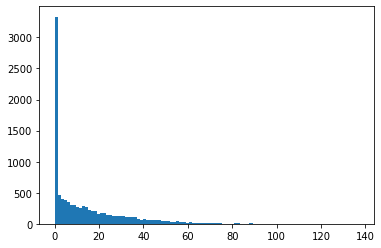

Durée d'exécution premier algo : 210.44838593199006
Price première méthode : 13.597161449107624


In [ ]:
plt.hist(price,bins=100)
plt.show()
print("Durée d'exécution premier algo :",np.sum(duree))
print("Price première méthode :",np.mean(price))